In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("datosCabaYGBA.csv",low_memory = False)

In [4]:
df.drop("Unnamed: 0",axis=1,inplace=True)

# Analizamos la evolucion del precio de una propiedad alrededor de la estacion de subte Las Heras, a traves del tiempo, tener en cuenta que se inauguró en diciembre de 2015

In [5]:
def propsEnZona(serie, zona):
    booleans = list()
    for item in serie:
        if item.split("|")[2] == zona:
            booleans.append(True)
        else:
            booleans.append(False)
    return booleans

In [6]:

propsCapital = df[propsEnZona(df.place_with_parent_names,"Capital Federal")]

In [7]:
propsCapital = propsCapital.dropna(subset = ["lat-lon"])

In [8]:
propsCapital = propsCapital[["property_type","created_on",\
                             "lat-lon","place_name","price_aprox_usd",\
                             "price_usd_per_m2","surface_total_in_m2"]]

In [9]:
propsRecoleta = propsCapital[propsCapital["place_name"] == "Recoleta"]

# Me quedo con propiedades con superficie total dentro de un determinado rango

In [10]:
from utils_analisis import latLonToInt,calcular_distancia
estacionLH = (-34.588203, -58.398268)


In [11]:
propsRecoleta["DistEstacionLH"] = propsRecoleta.apply(lambda row: calcular_distancia(latLonToInt(row["lat-lon"]),estacionLH),axis=1)

/home/tomas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
#Me quedo con las propiedades que estan en unradio de 600 metros de la stacion LH y con un tamaño dentro del promedio
cercanas = propsRecoleta[propsRecoleta["DistEstacionLH"] <= 0.8 ]
promSupTotal = cercanas["surface_total_in_m2"].mean()
cercanas = cercanas[(cercanas["surface_total_in_m2"] < promSupTotal + 20 ) & (cercanas["surface_total_in_m2"] > promSupTotal - 20 )]

In [13]:
cercanas["YearMonthCreation"] = cercanas.apply(lambda row:\
                                "-".join(row["created_on"].split("-")[:2]),axis=1)

In [14]:
#La propiedad con index 174462 tiene un precio por m2 muy extraño en comparacion a otras. Lo elimino

In [15]:
grouped = cercanas.loc[:,['YearMonthCreation','price_aprox_usd']].groupby('YearMonthCreation').\
    agg([np.mean])

In [16]:
grouped.index.rename("Año - mes",inplace= True)


# Estudio que pasa en tiempos cercanos a la inauguracion del subte

In [17]:
import matplotlib.dates as mdates

In [18]:
grouped = grouped.loc[(grouped.index < '2017-09') & (grouped.index > '2015-10')]

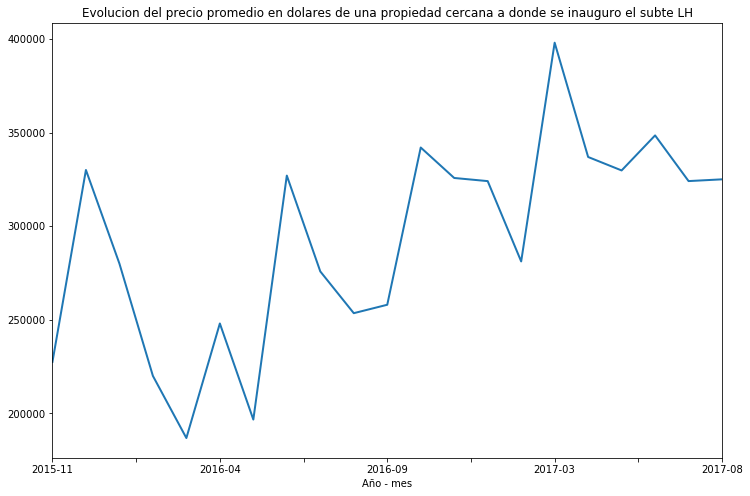

In [19]:

grouped.plot(linewidth=2,figsize=(12,8),legend=False,title="Evolucion del precio promedio en dolares de una propiedad cercana a donde se inauguro el subte LH")

In [20]:
plt.show()

# Se observa un incremento del precio de las propiedades en general a lo largo del tiempo luego de la inauguracion del subte

In [21]:
propiedadesBelgrano = df[df["place_name"] == "Belgrano"]

# Estudio como varia el precio de una tienda cuando me alejo de los principales medios de transporte de la zona

In [139]:
from pos_subtes_y_trenes_capital import medios_transporte

In [140]:
propsCapital = propsCapital[propsCapital["price_aprox_usd"] > 0]

In [141]:
propsCapital["distMinTransporte"] = propsCapital.apply(lambda row: min(calcular_distancia(latLonToInt(row["lat-lon"]),x) for x in medios_transporte),axis=1)

In [142]:
menorA5km = propsCapital[propsCapital["distMinTransporte"] < 5]

In [143]:
apartments = menorA10km[menorA5km["property_type"] == "apartment"]

/home/tomas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [144]:
#Me quedo con propiedades que valgan menos que el promedio + medio millon de dolares menos 
apartments = apartments[apartments["price_aprox_usd"] < apartments["price_aprox_usd"].mean() + 500000]


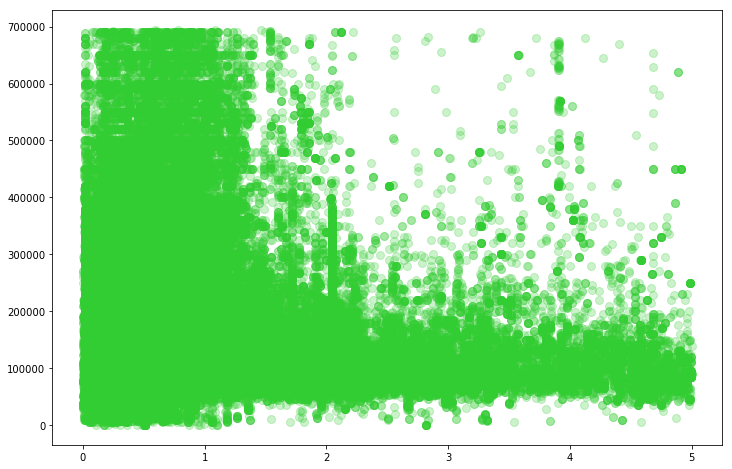

In [145]:

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(apartments.distMinTransporte, apartments.price_aprox_usd, marker="o", linestyle='', ms=8,color="limegreen", label="Apartment", alpha= 0.25)
plt.show()

### Se observa como a medida de que me alejo mas de toda estacion de subte 